# Linear Regression with Theano
In this tutorial we will move the first steps in the [Theano](http://deeplearning.net/software/theano/) library, a popular tensor manipulation library that provides automatic differentiation. We will learn the basics implementing a simple linear regression solver.

## Remember multivariate linear regression?

Recall that given a dataset $\{(x_i, y_i)\}_{i=0}^N$, with $x_i \in \mathbb{R}^d, y_i \in \mathbb{R}$, the objective of linear regression is to find a vector $w \in \mathbb{R}^d$ and a scalar $b$ such that $y = w^Tx + b$ fits the dataset. In this tutorial we will learn $w$ and $b$ using SGD and a Mean Square Error (MSE) loss:

$$L = \frac{1}{N} \sum_{i=0}^N (w^Tx_i + b - y_i)^2$$

Starting from random values, parameters $w$ and $b$ will be updated at each iteration via the following rule:

$$w_t = w_{t-1} - \eta \frac{\partial L}{\partial w}$$
$$b_t = b_{t-1} - \eta \frac{\partial L}{\partial b}$$

where $\eta$ represents the learning rate of our optimizer.


## A real problem to solve
Data we will use is from the [House Pricing Kaggle Competition](http://www.kaggle.com/c/house-prices-advanced-regression-techniques/). The proposed challenge is to predict a house price given other 79 variables, describing various aspects of it. Notice that this problem is hard and highly non-linear but, for the sake of this tutorial, we will use only real-valued features (about 30 variables) and a linear model.
The function we will use to load data will
* load data from the csv file into a numpy array;
* remove columns containing non numerical or incomplete data;
* shuffle the entire set
* separate observations from targets
* optionally add artificial quadratic features (simply as product of the existing ones)
* split into training and validation samples

and will look like this:

In [1]:
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import random

def get_data(non_linearities=False, train_ratio=0.8):

    # Load data
    data = np.genfromtxt('train.csv', delimiter=',').astype(np.float32)
    data = data[:, ~np.isnan(data).any(axis=0)]

    # Shuffle data
    random.shuffle(data)

    # separate into observations and targets
    X = data[:, 1:-1]
    Y = data[:, -1]

    # Optionally add non linear features
    if non_linearities:
        X_cl = X.copy()
        n_var = X.shape[1]
        for i in range(0, n_var):
            for j in range(i, n_var):
                f = np.expand_dims(X_cl[:, i]*X_cl[:, j], axis=1)
                if f.max() != 0:
                    X = np.concatenate((X, f), axis=1)

    # normalize X
    x_norm = np.max(X, axis=0)
    X /= x_norm

    # Split into train and validation
    X_train = X[0:int(X.shape[0]*train_ratio), :]
    Y_train = Y[0:int(Y.shape[0]*train_ratio)]
    X_val = X[int(X.shape[0]*train_ratio)::, :]
    Y_val = Y[int(Y.shape[0]*train_ratio)::]

    return X_train, Y_train, X_val, Y_val

# Load data
X_train, Y_train, X_val, Y_val = get_data()
n_feat = X_train.shape[1]

print X_train.shape
print '{} Training samples'.format(X_train.shape[0])
print '{} Validation samples'.format(X_val.shape[0])
print '{} observed variables'.format(n_feat)

Using Theano backend.
Using gpu device 0: Quadro K2200 (CNMeM is disabled, cuDNN 5103)


(1168L, 33L)
1168 Training samples
292 Validation samples
33 observed variables


## Let's start!
### Placeholders and variables
To implement and run a linear model, we will use the [Keras backend module](http://keras.io/backend/), which provides an abstraction over Theano.

First of all, we define the necessary variables and placeholders for our computational graph. Variables maintain state across executions of the computational graph, while placeholders are ways to feed the graph with external data.

For the linear regression example, we need three variables: `w`, `b`, and the learning rate for SGD, `lr`. Two placeholders `x` and `target` are created to store $x_i$ and $y_i$ values.

In [2]:
# Placeholders and variables
x = K.placeholder(shape=(None, n_feat))
target = K.placeholder(shape=(1,))
lr = K.variable(0.01)
w = K.variable(np.random.rand(n_feat))
b = K.variable(np.random.rand())

### Model definition
Now we can define the $y = w^Tx + b$ relation as well as the MSE loss in the computational graph.

In [3]:
# Define model and loss
y = K.dot(x, w) + b
loss = K.mean(K.square(y-target))
eval_loss = K.function(inputs=[x, target], outputs=[loss])

Then, given the gradient of MSE wrt to `w` and `b`, we can define how we update the parameters via SGD:

In [4]:
# Gradients
grads = K.gradients(loss, [w, b])
updates = [[w, w-lr*grads[0]], [b, b-lr*grads[1]]]

The whole model can be encapsulated in a `function`, which takes as input `x` and `target`, returns the current loss value and updates its parameter according to `updates`.

In [5]:
# Training function
train = K.function(inputs=[x, target], outputs=[loss], updates=updates)

### Training
Training is now just a matter of calling the `function` we have just defined. Each time `train` is called, indeed, `w` and `b` will be updated using the SGD rule.

We define a number of epochs at each of wich our dataset will be scanned. We can monitor both the loss on training and validation sets keeping a list, and print them and plot them as well.

Training loss: 3996341248.000 	 Validation loss: 3552807936.000
Training loss: 3689057024.000 	 Validation loss: 3352043776.000
Training loss: 3501405696.000 	 Validation loss: 3167929856.000
Training loss: 3328795136.000 	 Validation loss: 2995115008.000
Training loss: 3169711104.000 	 Validation loss: 2835941120.000
Training loss: 3023050752.000 	 Validation loss: 2689476352.000
Training loss: 2887803392.000 	 Validation loss: 2554693120.000
Training loss: 2763044352.000 	 Validation loss: 2430641408.000
Training loss: 2647923200.000 	 Validation loss: 2316445696.000
Training loss: 2541661696.000 	 Validation loss: 2211307520.000
Training loss: 2443544832.000 	 Validation loss: 2114490496.000
Training loss: 2352917248.000 	 Validation loss: 2025321344.000
Training loss: 2269178112.000 	 Validation loss: 1943180800.000
Training loss: 2191774976.000 	 Validation loss: 1867500800.000
Training loss: 2120200960.000 	 Validation loss: 1797761280.000
Training loss: 2053991552.000 	 Validati

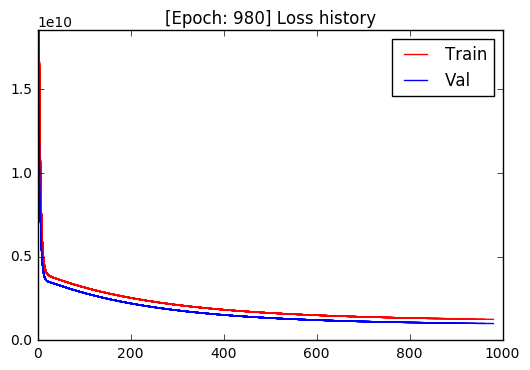

In [6]:
train_loss_history = []
val_loss_history = []
nb_epochs = 1000
for epoch in range(nb_epochs):
    train_loss = train([X_train, Y_train])[0]
    train_loss_history.append(train_loss)

    val_loss = eval_loss([X_val, Y_val])[0]
    val_loss_history.append(val_loss)

    # Print and plot
    if epoch % 20 == 0 and epoch != 0:
        print "Training loss: %.03f \t Validation loss: %.03f" % (train_loss, val_loss)

        # Plot loss history
        tr, = plt.plot(train_loss_history, c='r')
        vl, = plt.plot(val_loss_history, c='b')
        plt.legend([tr, vl], ['Train', 'Val'])
        plt.xlim(0, nb_epochs)
        plt.ylim(0, max(max(train_loss_history[3:]), max(val_loss_history[3:])))
        plt.title('[Epoch: {}] Loss history'.format(epoch))
            
        plt.draw()
        plt.pause(0.001)

# Final plot (still)
plt.show()